## 1. Requirements

In [1]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Set Args

In [3]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cpu')

## 3. Prepare Data

In [4]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json"))
#print(class_idx)
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
#print(idx2label)

In [5]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])

In [6]:
def image_folder_custom_label(root, transform, custom_label) :
    
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root = root, transform = transform)
    old_classes = old_data.classes
    
    label2idx = {}
    
    for i, item in enumerate(idx2label) :
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                 target_transform = lambda x : custom_label.index(old_classes[x]))
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data

In [15]:
normal_data = image_folder_custom_label(root = './data/imagenet', transform = transform, custom_label = idx2label)
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)



1

In [8]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

True Image & True Label


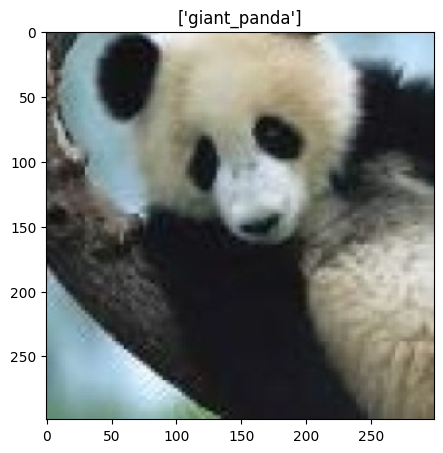

In [9]:
normal_iter = iter(normal_loader)
images, labels = next(normal_iter)

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])

## 4. Download the Inception v3

In [18]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [19]:
model = models.inception_v3(pretrained=True).to(device)

True Image & Predicted Label


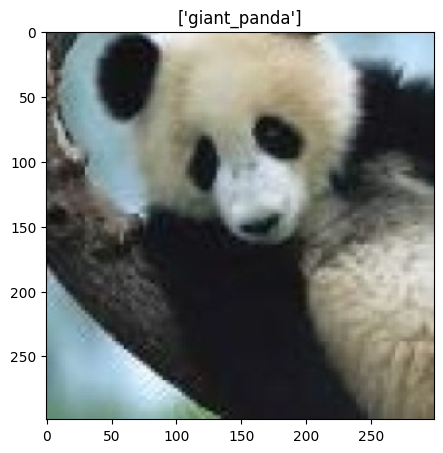

Accuracy of test text: 100.000000 %


In [20]:
print("True Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
        
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

## 5. Adversarial Attack

$$\delta_{i} = \frac{1}{2}(tanh(w_{i})+1)-x_i$$   
$$minmize \Vert \frac{1}{2}(tanh(w)+1)-x\Vert^2_2 + c\cdot f(\frac{1}{2}(tanh(w)+1))$$   
$$f(x')=max(max\{ Z(x')_i:i\neq t \} - Z(x')_t, -\kappa) $$      

* Notation - $w$ : modifier, $t$ : class that $x'$ will be classified, $\kappa$ : confidence, $Z$ : classifier without last softmax

In [21]:
# CW-L2 Attack
# Based on the paper, i.e. not exact same version of the code on https://github.com/carlini/nn_robust_attacks
# (1) Binary search method for c, (2) Optimization on tanh space, (3) Choosing method best l2 adversaries is NOT IN THIS CODE.
def cw_l2_attack(model, images, labels, targeted=False, c=1e-4, kappa=0, max_iter=1000, learning_rate=0.01) :

    images = images.to(device)     
    labels = labels.to(device)

    # Define f-function
    def f(x) :

        outputs = model(x)
        one_hot_labels = torch.eye(len(outputs[0]))[labels].to(device)

        i, _ = torch.max((1-one_hot_labels)*outputs, dim=1)
        j = torch.masked_select(outputs, one_hot_labels.byte())
        
        # If targeted, optimize for making the other class most likely 
        if targeted :
            return torch.clamp(i-j, min=-kappa)
        
        # If untargeted, optimize for making the other class most likely 
        else :
            return torch.clamp(j-i, min=-kappa)
    
    w = torch.zeros_like(images, requires_grad=True).to(device)

    optimizer = optim.Adam([w], lr=learning_rate)

    prev = 1e10
    
    for step in range(max_iter) :

        a = 1/2*(nn.Tanh()(w) + 1)

        loss1 = nn.MSELoss(reduction='sum')(a, images)
        loss2 = torch.sum(c*f(a))

        cost = loss1 + loss2

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        # Early Stop when loss does not converge.
        if step % (max_iter//10) == 0 :
            if cost > prev :
                print('Attack Stopped due to CONVERGENCE....')
                return a
            prev = cost
        
        print('- Learning Progress : %2.2f %%        ' %((step+1)/max_iter*100), end='\r')

    attack_images = 1/2*(nn.Tanh()(w) + 1)

    return attack_images

Attack Image & Predicted Label


/var/folders/pt/r12q15hd1nsblppxpr1krg040000gn/T/ipykernel_29508/3623800637.py:16: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1730.)
  j = torch.masked_select(outputs, one_hot_labels.byte())


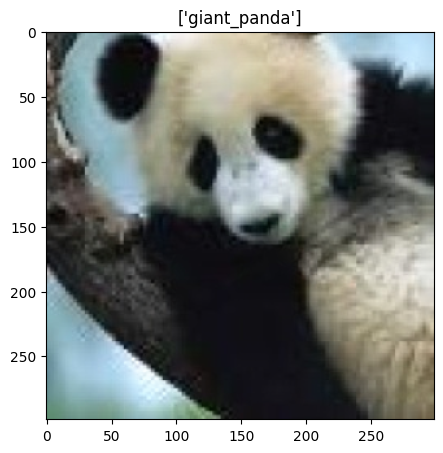

Accuracy of test text: 100.000000 %


In [22]:
print("Attack Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = cw_l2_attack(model, images, labels, targeted=False, c=0.1)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)

    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))